In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista
!pip install Rtree

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone --single-branch -b "collapse-iter-dev" "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [3]:
import xii

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [4]:
WD_PATH = "/content/drive/MyDrive/Research/3d-1d"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib
from graphnics import *

In [5]:
import GraphUtility
importlib.reload(GraphUtility)

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

diag_path = [0, 1, 2, 6]
try:
    G, original_to_new, edge_to_new_nodes = GraphUtility.build_graph(TEST_GRAPH_NODES, TEST_GRAPH_EDGES, 10)
    intermediate_nodes = GraphUtility.get_new_nodes_along_path(diag_path, edge_to_new_nodes)
    print("New (intermediate) nodes along the path:", intermediate_nodes)
except ValueError as e:
    print("Invalid path:", e)

New (intermediate) nodes along the path: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [6]:
import FEMSinkVelo

In [7]:
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSinkVelo.py'>

In [8]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 0,
    gamma_R = 1.0e-5,
    gamma_v = 1.0e-5,
    gamma_a = 1.0e-13,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 3.33e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008,
    original_to_new = original_to_new
)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_86765630720c088a2ad90ee684d3948b5df76d5b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.004951 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_22bb736b850c370ac1741e1a80b6653eae2ad213

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.019006 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.075963 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cdd21d347a8b939a40c5cd04a75bdb0e0e4b85cb

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00655389 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.504542 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7a13db3e62df35cb076482f827a4c3a63ea1ca80

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0121179 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0605965 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_99e64e64a0b0bf7efa2745c3166b98a12c5ca04c

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00601625 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0238416 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_13ad989b1a5f0cb94daaf558284587c298a5187f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_122, f_124]'
  Unique elements:           'DG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(?,?)>, CG1
                             (?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: au

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0e559bb996587dc58f3fceedb54558f2cf032454

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00377464 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0165339 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_5e5241c998fccd3b916405f6926290723f6a1ae6

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00410914 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing r

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_aeebad5a973881485d64eebf7ae831081e303822

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0046103 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.01494 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e72db44124fbfb039c1c7f38f8b9761b11f905e8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00385118 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0170567 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_2e0427e90a841c82831c9e8b32364eced707743b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00689816 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0157745 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_ecb3fd63d7ddd55feb692ec4d0f046834537be75

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00641537 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0138788 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_168a6722b3e7decf2e6398731db591b81c053fa6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_123]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0568581 seconds.

INFO:FFC:Compiler

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_18ef23f05d0effd386d0c875976458dbea712fa9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0031476 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0157979 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e1e8307b7239af85742309df96007de46566bd94

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00673318 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0310349 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_89024ca3e04ccffeb95c1589e5b2b8d31d162db6

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00946689 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.033778 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_6479fe16a617c3d73e6600e39e9829ec49ac76ab

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00706458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0366881 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5d97f418a5656246a8ebc574d2b9dcfbce41b2e6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of exterior_facet subdomains: 2
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              1
  Coefficients:                        '[f_125]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_856c0c66b2bfcf3ca5405291f42c619d70e1d00a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_122, f_126]'
  Unique elements:           'DG1(?,?), CG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(
                             ?,?)>'
  Unique sub elements:       'DG1(?,?), CG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(
                             ?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2546bfdc7cf4a4c21bcd27074b8d18c3c2bf8dcd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_122, f_127]'
  Unique elements:           'CG1(?,?), DG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(
                             ?,?)>'
  Unique sub elements:       'CG1(?,?), DG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(
                             ?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0281673503960dfc8d5161dde8fb26a8c43c38ad

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 1
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              4
  Coefficients:                        '[f_122, f_128, f_129, f_130]'
  Unique elements:                     'CG1(?,?), CG5(?,?), R0(?,?), Vector<3 x CG1(
      

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4d5e2edb2da87f7f643eb82ef2150cdea07c50f1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of exterior_facet subdomains: 2
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              2
  Coefficients:                        '[f_131, f_132]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quad

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a2f66506c04aa7f21a316554c72eb030fbb69a27

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of exterior_facet subdomains: 1
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              2
  Coefficients:                        '[f_133, f_134]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadra

Applied BC! Non-empty list
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d0280b54b788351a9a1c721dfa1d7a2c33a1e4f4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00449777 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0464091 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a39dc00bc629ed3985ced5cf85c36f77e87a033e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<3 x CG1(?,?)>'
  Unique sub elements:       'Vector<3 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0482836 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_39b0937af70ed9639aa8275281b20cc29957d051

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[3D Pressure, f_218]'
  Unique elements:           'Vector<3 x CG1(?,?)>, CG1(?,?), R0(?,?)'
  Unique sub elements:       'Vector<3 x CG1(?,?)>, CG1(?,?), R0(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0325303 seconds.

INFO:FFC:

In [9]:
fem_test.calculate_1d_inflow()

6.825422803941364e-07

In [10]:
import Visualizer
importlib.reload(Visualizer)

<module 'Visualizer' from '/content/drive/MyDrive/Research/3d-1d/modules/Visualizer.py'>

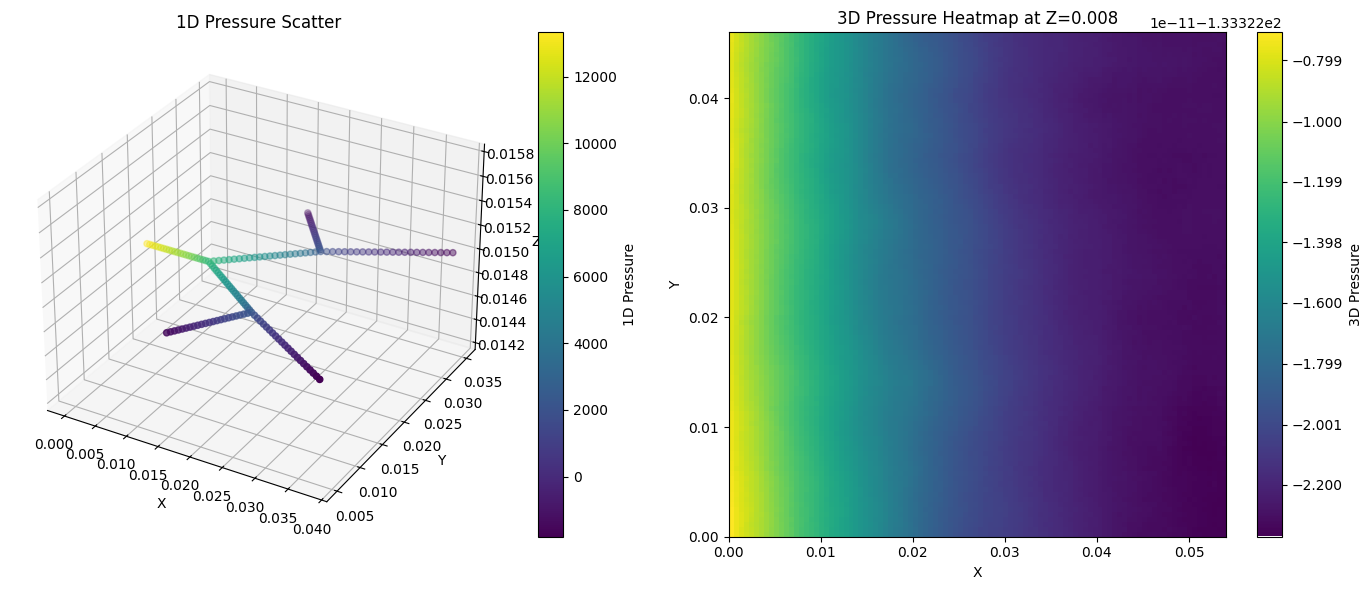

In [11]:
Visualizer.plot(fem_test.uh1d, fem_test.uh3d)

Node Pressure Data:
Node 8: Pressure 12961.5
Node 9: Pressure 12590.8
Node 10: Pressure 12220.1
Node 11: Pressure 11849.4
Node 12: Pressure 11478.7
Node 13: Pressure 11108.0
Node 14: Pressure 10737.3
Node 15: Pressure 10291.1
Node 16: Pressure 9632.1
Node 17: Pressure 8973.1
Node 18: Pressure 7855.7
Node 19: Pressure 7397.3
Node 20: Pressure 6938.9
Node 21: Pressure 6480.5
Node 22: Pressure 6022.2
Node 23: Pressure 5563.8
Node 24: Pressure 5105.4
Node 25: Pressure 4647.0
Node 26: Pressure 4188.7
Node 27: Pressure 3396.2
Node 48: Pressure 1610.6
Node 49: Pressure 1209.6
Node 50: Pressure 874.3
Node 51: Pressure 539.1
Node 52: Pressure 203.8
Node 53: Pressure -131.4
Node 54: Pressure -466.7
Node 55: Pressure -801.9
Node 56: Pressure -1137.1
Node 57: Pressure -1472.4


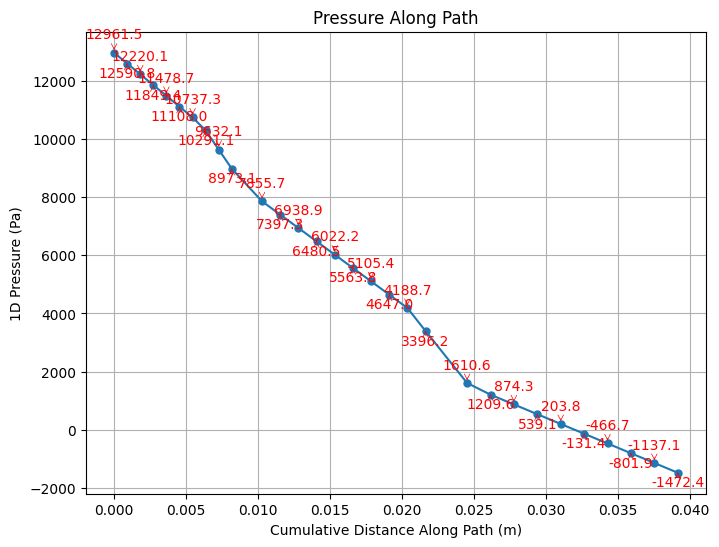

In [ ]:
Visualizer.plot_path_pressure(fem_test.uh1d, intermediate_nodes)

In [ ]:
print(fem_test.calculate_total_outflow())
print(fem_test.calculate_1d_inflow())

9.783564462835776e-05
9.783564462835776e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 872.88it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 911.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 855.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 572.70it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 450.20it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 915.53it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 905.31it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 913.14it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 896.27it/s]


Applied BC! Non-empty list
Iteration 1: parameters (log scale) = [ 0.06  -0.2    0.06   0.06  -7.994], cost = 8.142383577136157e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 476.77it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 540.35it/s]


Applied BC! Non-empty list
Iteration 2: parameters (log scale) = [ 0.06  -0.2    0.06   0.06  -7.994], cost = 8.142383577136157e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 914.91it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 930.17it/s]


Applied BC! Non-empty list
Iteration 3: parameters (log scale) = [ 0.06  -0.2    0.06   0.06  -7.994], cost = 8.142383577136157e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 914.53it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 899.84it/s]


Applied BC! Non-empty list
Iteration 4: parameters (log scale) = [ 0.06  -0.2    0.06   0.06  -7.994], cost = 8.142383577136157e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 540.51it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 578.80it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 870.54it/s]


Applied BC! Non-empty list
Iteration 5: parameters (log scale) = [ 0.061824  -0.32928    0.263424   0.119424  -8.0018816], cost = 7.005172412180478e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 752.42it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 950.12it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 939.22it/s]


Applied BC! Non-empty list
Iteration 6: parameters (log scale) = [ 0.0989184  -0.526848    0.1614784   0.1910784  -8.00301056], cost = 5.3703726320611854e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 933.11it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 557.51it/s]


Applied BC! Non-empty list
Iteration 7: parameters (log scale) = [ 0.0989184  -0.526848    0.1614784   0.1910784  -8.00301056], cost = 5.3703726320611854e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 938.29it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 901.08it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 864.81it/s]


Applied BC! Non-empty list
Iteration 8: parameters (log scale) = [ 0.26045722 -0.77373952  0.31659162  0.10289562 -7.99413565], cost = 3.083107588768816e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 704.08it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 880.28it/s]


Applied BC! Non-empty list
Iteration 9: parameters (log scale) = [ 0.26045722 -0.77373952  0.31659162  0.10289562 -7.99413565], cost = 3.083107588768816e-05


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 577.32it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 547.34it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 887.77it/s]


Applied BC! Non-empty list
Iteration 10: parameters (log scale) = [ 0.24391056 -1.30098452  0.62341162  0.34633258 -8.00296563], cost = 7.300983416029727e-06


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 954.46it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 937.50it/s]


Applied BC! Non-empty list
Iteration 11: parameters (log scale) = [ 0.24391056 -1.30098452  0.62341162  0.34633258 -8.00296563], cost = 7.300983416029727e-06


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 957.97it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 575.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 516.04it/s]


Applied BC! Non-empty list
Iteration 12: parameters (log scale) = [ 0.58395941 -1.83011702  0.62357137  0.47485032 -8.00644821], cost = 5.091217471960037e-07


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 856.60it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 889.16it/s]


Applied BC! Non-empty list
Iteration 13: parameters (log scale) = [ 0.58395941 -1.83011702  0.62357137  0.47485032 -8.00644821], cost = 5.091217471960037e-07


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 710.11it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 934.00it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 565.19it/s]


Applied BC! Non-empty list
Iteration 14: parameters (log scale) = [ 0.76972978 -2.63736809  1.03698065  0.45934374 -8.00661489], cost = 4.158920299288352e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 510.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 706.49it/s]


Applied BC! Non-empty list
Iteration 15: parameters (log scale) = [ 0.76972978 -2.63736809  1.03698065  0.45934374 -8.00661489], cost = 4.158920299288352e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 826.77it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 821.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 871.34it/s]


Applied BC! Non-empty list
Iteration 16: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 462.27it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 517.99it/s]


Applied BC! Non-empty list
Iteration 17: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 818.09it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 756.23it/s]


Applied BC! Non-empty list
Iteration 18: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 774.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 884.99it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 862.48it/s]


Applied BC! Non-empty list
Iteration 19: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 572.78it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 742.94it/s]


Applied BC! Non-empty list
Iteration 20: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 927.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 929.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 760.28it/s]


Applied BC! Non-empty list
Iteration 21: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 854.65it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 514.64it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 792.04it/s]


Applied BC! Non-empty list
Iteration 22: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 946.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 880.81it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 838.81it/s]


Applied BC! Non-empty list
Iteration 23: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 855.69it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 535.26it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 485.00it/s]


Applied BC! Non-empty list
Iteration 24: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 909.23it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 931.29it/s]


Applied BC! Non-empty list
Iteration 25: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 801.88it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 919.82it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 626.71it/s]


Applied BC! Non-empty list
Iteration 26: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 466.17it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 878.09it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 955.90it/s]


Applied BC! Non-empty list
Iteration 27: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 935.02it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 862.87it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 899.78it/s]


Applied BC! Non-empty list
Iteration 28: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 561.78it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 887.91it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 894.14it/s]


Applied BC! Non-empty list
Iteration 29: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 754.57it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 943.18it/s]


Applied BC! Non-empty list
Iteration 30: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 905.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 598.42it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 471.18it/s]


Applied BC! Non-empty list
Iteration 31: parameters (log scale) = [ 0.86058221 -2.93451789  1.2435365   0.65798576 -8.01354205], cost = 3.67802346880152e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 924.41it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 927.21it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 903.07it/s]


Applied BC! Non-empty list
Iteration 32: parameters (log scale) = [ 0.90346049 -2.84184647  1.25872388  0.54304185 -8.01707498], cost = 3.375691836823843e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 935.81it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 925.60it/s]


Applied BC! Non-empty list
Iteration 33: parameters (log scale) = [ 0.90346049 -2.84184647  1.25872388  0.54304185 -8.01707498], cost = 3.375691836823843e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 628.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 896.16it/s]


Applied BC! Non-empty list
Iteration 34: parameters (log scale) = [ 0.90346049 -2.84184647  1.25872388  0.54304185 -8.01707498], cost = 3.375691836823843e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 898.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 856.42it/s]


Applied BC! Non-empty list
Iteration 35: parameters (log scale) = [ 0.90346049 -2.84184647  1.25872388  0.54304185 -8.01707498], cost = 3.375691836823843e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 925.37it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 931.58it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 594.56it/s]


Applied BC! Non-empty list
Iteration 36: parameters (log scale) = [ 1.04157694 -2.96629991  1.49408441  0.61855873 -8.02689714], cost = 3.270332521612351e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 545.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 878.77it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 934.82it/s]


Applied BC! Non-empty list
Iteration 37: parameters (log scale) = [ 1.07290207 -2.75802126  1.37264216  0.39156181 -8.02507683], cost = 2.8067067675736363e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 928.63it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 947.54it/s]


Applied BC! Non-empty list
Iteration 38: parameters (log scale) = [ 1.07290207 -2.75802126  1.37264216  0.39156181 -8.02507683], cost = 2.8067067675736363e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 585.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 496.97it/s]


Applied BC! Non-empty list
Iteration 39: parameters (log scale) = [ 1.07290207 -2.75802126  1.37264216  0.39156181 -8.02507683], cost = 2.8067067675736363e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 728.44it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 886.40it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 889.82it/s]


Applied BC! Non-empty list
Iteration 40: parameters (log scale) = [ 1.21818299 -2.76826264  1.70904479  0.4160386  -8.04489196], cost = 2.4358915602829765e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 870.48it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 576.62it/s]


Applied BC! Non-empty list
Iteration 41: parameters (log scale) = [ 1.21818299 -2.76826264  1.70904479  0.4160386  -8.04489196], cost = 2.4358915602829765e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 514.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 786.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 815.56it/s]


Applied BC! Non-empty list
Iteration 42: parameters (log scale) = [ 1.35508134 -2.54051685  1.71424528  0.0461647  -8.04706465], cost = 1.9930516255560765e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 798.22it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 896.02it/s]


Applied BC! Non-empty list
Iteration 43: parameters (log scale) = [ 1.35508134 -2.54051685  1.71424528  0.0461647  -8.04706465], cost = 1.9930516255560765e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 514.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 536.26it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 870.45it/s]


Applied BC! Non-empty list
Iteration 44: parameters (log scale) = [ 1.67264178 -2.48048322  2.0335026  -0.04204288 -8.07259309], cost = 1.4692624148231057e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 815.52it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 884.67it/s]


Applied BC! Non-empty list
Iteration 45: parameters (log scale) = [ 1.67264178 -2.48048322  2.0335026  -0.04204288 -8.07259309], cost = 1.4692624148231057e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 886.91it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 508.71it/s]


Applied BC! Non-empty list
Iteration 46: parameters (log scale) = [ 1.67264178 -2.48048322  2.0335026  -0.04204288 -8.07259309], cost = 1.4692624148231057e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 500.62it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 797.59it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 725.24it/s]


Applied BC! Non-empty list
Iteration 47: parameters (log scale) = [ 1.77775079 -2.1775456   2.1163502  -0.37213904 -8.07990246], cost = 1.427968886588948e-08


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 876.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 932.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 564.53it/s]


Applied BC! Non-empty list
Iteration 48: parameters (log scale) = [ 2.30326465 -2.11628874  2.66163887 -0.7231054  -8.11758201], cost = 8.862673603977106e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 524.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 923.52it/s]


Applied BC! Non-empty list
Iteration 49: parameters (log scale) = [ 2.30326465 -2.11628874  2.66163887 -0.7231054  -8.11758201], cost = 8.862673603977106e-09


<ipython-input-112-34ea4529549c>:71: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(
Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 904.43it/s]


Applied BC! Non-empty list


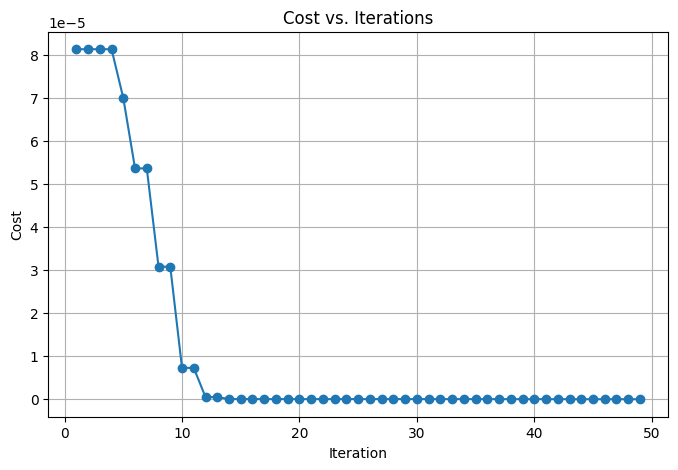

Optimization successful? False
Status code: 2
Message: Maximum number of iterations has been exceeded.
Number of iterations: 50
Final cost: 8.862673603977106e-09
gamma    =      201
gamma_R  = 0.007651
gamma_a  =    458.8
gamma_v  =   0.1892
k_v      = 7.628e-09
flow     = 9.914e-05


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def black_box_flow(gamma, gamma_R, gamma_a, gamma_v, k_v):
    fem_test = FEMSinkVelo.FEMSinkVelo(
        G=G,
        gamma=gamma,
        gamma_R=gamma_R,
        gamma_a=gamma_a,
        gamma_v=gamma_v,
        mu=1.0e-3,
        k_t=1.0e-10,
        k_v=k_v,
        P_in=100.0*133.322,
        p_cvp=1.0*133.322,
        Lambda_inlet=[0],
        Lambda_padding_min=0.008,
        original_to_new=original_to_new
    )
    flow_val = fem_test.calculate_1d_inflow()
    return flow_val

def cost_function_log(params_log, target_flow):
    # Unpack parameters in log-space and convert to linear scale
    gamma_linear   = 10.0**(params_log[0])
    gamma_R_linear = 10.0**(params_log[1])
    gamma_a_linear = 10.0**(params_log[2])
    gamma_v_linear = 10.0**(params_log[3])
    k_v_linear     = 10.0**(params_log[4])

    # Evaluate the flow from the PDE solver
    flow_val = black_box_flow(
        gamma_linear,
        gamma_R_linear,
        gamma_a_linear,
        gamma_v_linear,
        k_v=k_v_linear
    )

    # Least-squares difference from the target flow
    return (flow_val - target_flow)**2

def multi_param_fit(
    target_flow=500.6,
    initial_guess_log=None,
    max_iter=50
):
    if initial_guess_log is None:
        initial_guess_log = [0.0, 0.0, 0.0, 0.0, -8.0]

    n_params = len(initial_guess_log)
    initial_simplex = [np.array(initial_guess_log)]
    for i in range(n_params):
        vertex = np.array(initial_guess_log, copy=True)
        if i == 4:  # k_v dimension: smaller step size
            vertex[i] += 0.01
        else:
            vertex[i] += 0.1
        initial_simplex.append(vertex)
    initial_simplex = np.array(initial_simplex)

    cost_history = []

    def callback(xk):
        cost = cost_function_log(xk, target_flow=target_flow)
        cost_history.append(cost)
        iteration_num = len(cost_history)
        print(f"Iteration {iteration_num}: parameters (log scale) = {xk}, cost = {cost}")

    result = minimize(
        fun=lambda p: cost_function_log(p, target_flow=target_flow),
        x0=np.array(initial_guess_log),
        method='Nelder-Mead',
        callback=callback,
        options={
            'maxiter': max_iter,
            'disp': True,
            'initial_simplex': initial_simplex
        }
    )

    best_log = result.x
    gamma_opt   = 10.0**(best_log[0])
    gammaR_opt  = 10.0**(best_log[1])
    gammaA_opt  = 10.0**(best_log[2])
    gammaV_opt  = 10.0**(best_log[3])
    k_v_opt     = 10.0**(best_log[4])

    flow_final = black_box_flow(gamma_opt, gammaR_opt, gammaA_opt, gammaV_opt, k_v_opt)

    # Plot the cost history
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cost_history) + 1), cost_history, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.grid(True)
    plt.show()

    return {
        'success': result.success,
        'status': result.status,
        'message': result.message,
        'n_iters': result.nit,
        'cost_final': result.fun,
        'gamma':   gamma_opt,
        'gamma_R': gammaR_opt,
        'gamma_a': gammaA_opt,
        'gamma_v': gammaV_opt,
        'k_v':     k_v_opt,
        'flow_final': flow_final,
        'cost_history': cost_history
    }

res = multi_param_fit(target_flow=5.0e-6, max_iter=50)

print("Optimization successful?", res['success'])
print("Status code:", res['status'])
print("Message:", res['message'])
print("Number of iterations:", res['n_iters'])
print("Final cost:", res['cost_final'])
print(f"gamma    = {res['gamma']:8.4g}")
print(f"gamma_R  = {res['gamma_R']:8.4g}")
print(f"gamma_a  = {res['gamma_a']:8.4g}")
print(f"gamma_v  = {res['gamma_v']:8.4g}")
print(f"k_v      = {res['k_v']:8.4g}")
print(f"flow     = {res['flow_final']:8.4g}")

In [ ]:
fem_test.save_vtk(os.path.join(WD_PATH, "perfusion_results", "23demo2.vtk"))